In [1]:
import sys
# append the path of the parent directory
sys.path.append("..")

In [18]:
import math
import os
import time


import numpy as np
np.set_printoptions(legacy='1.25')

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.patches as patches

import seaborn as sns
import time
import json
import pandas as pd
from ctypes import c_int32
from itertools import product
import copy


from tqdm import tqdm

from scipy.stats import pearsonr
from importlib import reload

import orjson
import gzip

from scipy.stats import entropy
from pympler import asizeof

from lib import sketches, visualization_utils, encoders, ploting, pacha_sketch
reload(ploting)
reload(sketches)
reload(visualization_utils)
reload(encoders)

reload(pacha_sketch)

from lib.sketches import BloomFilter, CountMinSketch, H3HashFunctions, HashFunctionFamily,\
      CountMinSketchHadamard, CountMinSketchLocalHashing, deterministic_hash, simple_deterministic_hash, \
      fast_hash_xx
from lib.visualization_utils import plot_boxplot

from lib.encoders import minimal_b_adic_cover, minimal_spatial_b_adic_cover, BAdicCube, BAdicRange, \
      minimal_b_adic_cover_array, downgrade_b_adic_range_indices
from lib.pacha_sketch import PachaSketch, ADTree, BFParameters, CMParameters, \
      cartesian_product, get_n_updates, MaterializedCombinations, get_n_updates_customized

from lib.ploting import set_style, plot_ylabel, plot_legend

from lib import baselines
reload(baselines)

from lib.baselines import CentralDPServer, LDPServer, LDPEncoderGRR, filter_df, query_df, \
      infer_domains_and_ranges, translate_query_region, evaluate_queries, check_accruracy, \
      evaluate_queries_baselines, evaluate_equivalent_pacha_sketches, compute_relative_entropy

# set_style()

In [3]:
def remove_ourliers(result_df):
    q1 = result_df['normalized_error'].quantile(0.25)
    q3 = result_df['normalized_error'].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    result_df_no_outliers = result_df[(result_df['normalized_error'] >= lower_bound) & (result_df['normalized_error'] <= upper_bound)].copy()
    return result_df_no_outliers

## Lineitem Scale

In [11]:
ad_tree_levels = 5
num_combinations = 13
cat_updates_tpch, num_updates_tpch, region_updates_tpch = get_n_updates_customized(ad_tree_levels, num_combinations, 5)

In [8]:
scale_factors = 4**np.arange(4) * 0.03125
n_elements = ['187 k', '750 k', '3 M', '12 M']

results = []
for sf, n in zip(scale_factors, n_elements):
    result_df = pd.read_csv(f"../results/tpch/scale/tpch_random_results_2_{sf}.csv")
    result_df_2 = pd.read_csv(f"../results/tpch/scale/tpch_random_results_{sf}.csv")
    result_df = pd.concat([result_df, result_df_2], ignore_index=True)
    result_df = result_df[result_df['b_adic_cubes'] < 50_000]
    result_df['approach'] = n
    results.append(result_df)

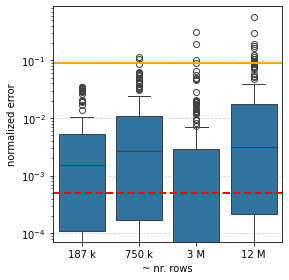

In [19]:
custom_palette = {
    '187 k': 'tab:blue',
    '750 k': 'tab:blue',
    '3 M': 'tab:blue',
    '12 M': 'tab:blue',
}
plot_boxplot(results, target=0.0005, log_scale=True, x_label='~ nr. rows', figsize=(4, 4), palette=custom_palette)

In [20]:
rel_entropies = []
rel_entropies_no_outliers = []
for result_df in results:
    rel_entropies.append(compute_relative_entropy(result_df))
    rel_entropies_no_outliers.append(compute_relative_entropy(remove_ourliers(result_df)))

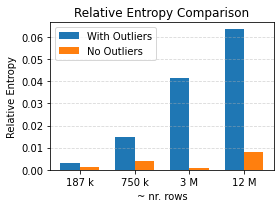

In [21]:
labels = n_elements
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(4, 3))
rects1 = ax.bar(x - width/2, rel_entropies, width, label='With Outliers')
rects2 = ax.bar(x + width/2, rel_entropies_no_outliers, width, label='No Outliers')

ax.set_ylabel('Relative Entropy')
ax.set_xlabel('~ nr. rows')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.grid(True, axis='y', alpha=0.5, linestyle='--')
ax.set_title('Relative Entropy Comparison')

plt.tight_layout()
plt.show()

In [85]:
rel_eps = 0.0005
levels = 5
delta = 0.01
bloom_p = 0.01
cat_col_map_tpch = [0, 1, 2, 3, 4]
n_cat_tpch = len(cat_col_map_tpch)
num_col_map_tpch = [5, 6, 7, 8, 9]
n_num_tpch = len(num_col_map_tpch)
bases_tpch = [5,5,5,10,2]

ad_tree_levels = len(cat_col_map_tpch)
num_combinations = 13
cat_updates_tpch, num_updates_tpch, region_updates_tpch = get_n_updates_customized(ad_tree_levels, num_combinations, levels)

error_eps = rel_eps / region_updates_tpch
sizes = []
for len_df in (4**np.arange(4) * 187500):
    size_details = []
    size_details.append(BFParameters(n_values=len_df * num_updates_tpch, p=bloom_p).peek_memory())
    size_details.append(BFParameters(n_values=len_df * region_updates_tpch, p=bloom_p).peek_memory())
    cm_size = CMParameters(delta=delta, error_eps=error_eps).peek_memory()
    size_details.append(cm_size * (levels - 1))
    size_details.append(cm_size)
    sizes.append(size_details)
sizes = np.array(sizes)

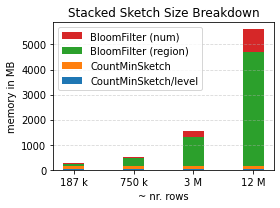

In [94]:
fig, ax = plt.subplots(figsize=(4, 3))
bottom = np.zeros(sizes.shape[0])
labels_stack = ['BloomFilter (num)', 'BloomFilter (region)', 'CountMinSketch', 'CountMinSketch/level']

for i in reversed(range(sizes.shape[1])):
    ax.bar(x, sizes[:, i], width, bottom=bottom, label=labels_stack[i])
    bottom += sizes[:, i]

ax.set_ylabel('memory in MB')
ax.set_xlabel('~ nr. rows')
ax.set_xticks(x)
ax.set_xticklabels(n_elements)
handles, legend_labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], legend_labels[::-1])
# plt.yscale('log')
plt.grid(True, axis='y', alpha=0.5, linestyle='--')
plt.title('Stacked Sketch Size Breakdown')
plt.tight_layout()
plt.show()

## Sketch Size

In [146]:
probs = 2**np.arange(7)*0.005
rel_epsilons = 2**np.arange(7) * 0.00025

labels = [f'p={p}, ε={eps}' for p, eps in zip(probs, rel_epsilons)]

results = []
for label, p, eps in zip(labels, probs, rel_epsilons):
    result_df = pd.read_csv(f"../results/tpch/size/tpch_random_results_0.1_eps_{eps}_p_{p}.csv")
    result_df_2 = pd.read_csv(f"../results/tpch/size/tpch_random_results_2_0.1_eps_{eps}_p_{p}.csv")
    result_df = pd.concat([result_df, result_df_2], ignore_index=True)
    result_df['approach'] = label
    results.append(result_df)

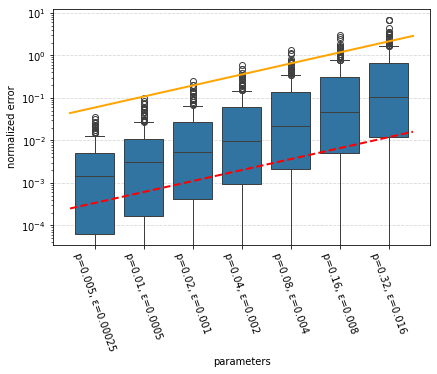

In [147]:
custom_palette = {}
for label in labels:
    custom_palette[label] = 'tab:blue'
plot_boxplot(results, log_scale=True, rotation=-70, target=rel_epsilons, x_label='parameters', figsize=(6, 4), palette=custom_palette)

In [115]:
rel_entropies = []
rel_entropies_no_outliers = []
for result_df in results:
    rel_entropies.append(compute_relative_entropy(result_df))
    rel_entropies_no_outliers.append(compute_relative_entropy(remove_ourliers(result_df)))

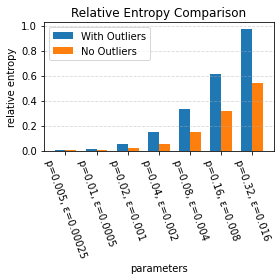

In [120]:
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(4, 4))
rects1 = ax.bar(x - width/2, rel_entropies, width, label='With Outliers')
rects2 = ax.bar(x + width/2, rel_entropies_no_outliers, width, label='No Outliers')

ax.set_ylabel('relative entropy')
ax.set_xlabel('parameters')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.grid(True, axis='y', alpha=0.5, linestyle='--')
ax.set_title('Relative Entropy Comparison')
plt.xticks(rotation=-70, ha='center')

plt.tight_layout()
plt.show()

In [121]:
lineitem_df = pd.read_parquet("../data/tpch/lineitem_0.1.parquet")
len_df = len(lineitem_df)

levels = 5
delta = 0.01
cat_col_map_tpch = [0, 1, 2, 3, 4]
n_cat_tpch = len(cat_col_map_tpch)
num_col_map_tpch = [5, 6, 7, 8, 9]
n_num_tpch = len(num_col_map_tpch)
bases_tpch = [5,5,5,10,2]

ad_tree_levels = len(cat_col_map_tpch)
num_combinations = 13
cat_updates_tpch, num_updates_tpch, region_updates_tpch = get_n_updates_customized(ad_tree_levels, num_combinations, levels)

sizes = []
for bloom_p, rel_eps in zip(probs, rel_epsilons):
    error_eps = rel_eps / region_updates_tpch
    size_details = []
    size_details.append(BFParameters(n_values=len_df * num_updates_tpch, p=bloom_p).peek_memory())
    size_details.append(BFParameters(n_values=len_df * region_updates_tpch, p=bloom_p).peek_memory())
    cm_size = CMParameters(delta=delta, error_eps=error_eps).peek_memory()
    size_details.append(cm_size * (levels - 1))
    size_details.append(cm_size)
    sizes.append(size_details)
sizes = np.array(sizes)

In [ ]:
BFParameters(n_values=len_df * region_updates_tpch, p=bloom_p).peek_memory()

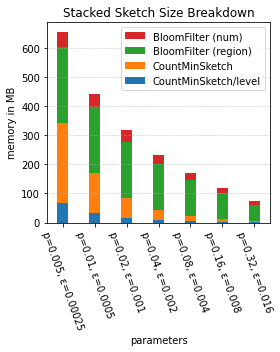

In [125]:
fig, ax = plt.subplots(figsize=(4, 5))
bottom = np.zeros(sizes.shape[0])
labels_stack = ['BloomFilter (num)', 'BloomFilter (region)', 'CountMinSketch', 'CountMinSketch/level']

for i in reversed(range(sizes.shape[1])):
    ax.bar(x, sizes[:, i], width, bottom=bottom, label=labels_stack[i])
    bottom += sizes[:, i]

ax.set_ylabel('memory in MB')
ax.set_xlabel('parameters')
ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.xticks(rotation=-70, ha='center')
handles, legend_labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], legend_labels[::-1])
# plt.yscale('log')
plt.grid(True, axis='y', alpha=0.5, linestyle='--')
plt.title('Stacked Sketch Size Breakdown')
plt.tight_layout()
plt.show()

## Different Queries

In [126]:
selectivities = np.array([0.01, 0.02, 0.04, 0.08, 0.16, 0.32, 0.64])

results = []
for sel in selectivities:
    result_df = pd.read_csv(f"../results/tpch/selectivities/tpch_sel_{sel}.csv")
    result_df['approach'] = sel
    results.append(result_df)

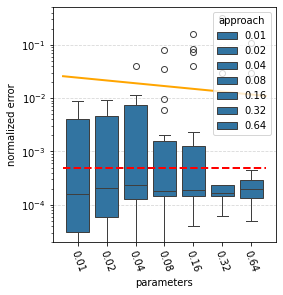

In [128]:
rel_epsilons = np.full(len(selectivities), 0.0005)
custom_palette = {}
for sel in selectivities:
    custom_palette[sel] = 'tab:blue'
plot_boxplot(results, log_scale=True, rotation=-70, target=rel_epsilons, x_label='parameters', figsize=(4, 4), palette=custom_palette)

In [138]:
n_dims = np.arange(1, 6)

results = []
for n in n_dims:
    result_df = pd.read_csv(f"../results/tpch/categorical/tpch_cat_{n}.csv")
    result_df['approach'] = n
    results.append(result_df)

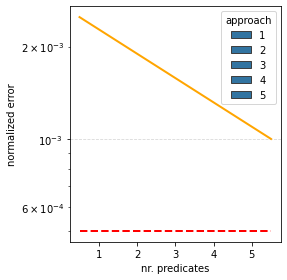

In [139]:
rel_epsilons = np.full(len(n_dims), 0.0005)
custom_palette = {}
for n in n_dims:
    custom_palette[n] = 'tab:blue'
plot_boxplot(results, log_scale=True, target=rel_epsilons, x_label='nr. predicates', figsize=(4, 4), palette=custom_palette)

In [140]:
n_dims = np.arange(1, 6)

results = []
for n in n_dims:
    result_df = pd.read_csv(f"../results/tpch/numerical/tpch_num_{n}.csv")
    result_df['approach'] = n
    results.append(result_df)

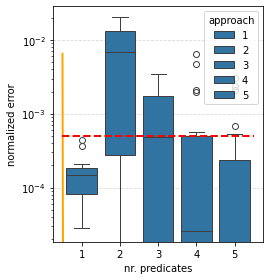

In [141]:
rel_epsilons = np.full(len(n_dims), 0.0005)
custom_palette = {}
for n in n_dims:
    custom_palette[n] = 'tab:blue'
plot_boxplot(results, log_scale=True, target=rel_epsilons, x_label='nr. predicates', figsize=(4, 4), palette=custom_palette)

In [142]:
n_dims = np.arange(1, 6)

results = []
for n in n_dims:
    result_df = pd.read_csv(f"../results/tpch/mixed/tpch_mix_{n}.csv")
    result_df['approach'] = 2*n
    results.append(result_df)

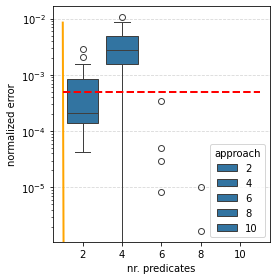

In [144]:
rel_epsilons = np.full(len(n_dims), 0.0005)
custom_palette = {}
for n in n_dims:
    custom_palette[2*n] = 'tab:blue'
plot_boxplot(results, log_scale=True, target=rel_epsilons, x_label='nr. predicates', figsize=(4, 4), palette=custom_palette)

# Fix Size (Streaming)

In [41]:
mem_budgets = (2**np.arange(6) * 64).astype(int)  
max_n = 0

results_medians = {}
results_25 = {}
results_75 = {}
not_valids = {}
for mem_budget in mem_budgets:
    medians = []
    quantiles_25 = []
    quantiles_75 = []
    not_valid = []
    for n in np.arange(170):
        try:                            
            result_df = pd.read_csv(f"../results/tpch/fix_size/tpch_fix_{mem_budget}_MB_{n}.csv")
        except FileNotFoundError:
            print(f"File not found for mem budget: {mem_budget}, n: {n}")
            # print(f"../results/tpch/fix_size/tpch_fix_{mem_budget}_{n}.csv")
            break
        result_df = result_df[result_df['b_adic_cubes'] < 50_000]
        if result_df.empty:
            print('No valid results for mem budget:', mem_budget, 'and n:', n)
            break
        med = result_df['normalized_error'].median()
        if med < 0.0 or med > 1.0:
            not_valid.append(n)
        medians.append(result_df['normalized_error'].median())
        quantiles_25.append(result_df['normalized_error'].quantile(0.25))
        quantiles_75.append(result_df['normalized_error'].quantile(0.75))
        max_n = max(max_n, n)
    results_medians[mem_budget] = medians
    results_25[mem_budget] = quantiles_25
    results_75[mem_budget] = quantiles_75
    not_valids[mem_budget] = not_valid


File not found for mem budget: 64, n: 0
File not found for mem budget: 128, n: 0
File not found for mem budget: 256, n: 0
File not found for mem budget: 512, n: 0
File not found for mem budget: 1024, n: 133
File not found for mem budget: 2048, n: 134


In [40]:
24_000_000 / 240 * 133

13300000.0

In [38]:
not_valids

{64: [2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120,
  121,
  122,
  123,
  124,
  125,
  126,
  127,
  128,
  129,
  130,
  131,
  132,
  133,
  134,
  135,
  136,
  137,
  138,
  139,
  140,
  141,
  142,
  143,
  144,
  145,
  146,
  147,
  148,
  149,
  150,
  151,
  152,
  153,
  154,
  155,
  156,
  157,
  158,
  1

In [ ]:
[  1_000,  25_000,  50_000,  50_000, 50_000, 50_000]

In [39]:
    
for mem_budget in 2**np.arange(6) * 64:
    print(f"Memory budget: {mem_budget} MB")
    levels = 5

    cat_col_map_tpch = [0, 1, 2, 3, 4]
    n_cat_tpch = len(cat_col_map_tpch)
    num_col_map_tpch = [5, 6, 7, 8, 9]
    n_num_tpch = len(num_col_map_tpch)
    bases_tpch = [5,5,5,10,2]

    ad_tree_levels = len(cat_col_map_tpch)
    num_combinations = 13
    cat_updates_tpch, num_updates_tpch, region_updates_tpch = get_n_updates_customized(ad_tree_levels, num_combinations, levels)

    mem_cms = mem_budget / 2
    
    rel_eps = 0.0005
    delta = 0.01
    error_eps = rel_eps / region_updates_tpch

    mem_cms = mem_budget * 0.75 / levels
    n_counters = mem_cms * 1024 * 1024 / 4
    depth = 3
    width = n_counters // depth
    error_eps = np.e/width
    while error_eps < rel_eps / region_updates_tpch and depth < 5:
        depth += 1
        width = n_counters // depth
        error_eps = np.e/width
    
    if error_eps < rel_eps / region_updates_tpch:
        error_eps = rel_eps / region_updates_tpch
        cms_params = CMParameters(delta=delta, error_eps=error_eps)
    else:
        cms_params = CMParameters(width=int(width), depth=int(depth))

    mem_cms = cms_params.peek_memory() * levels
   
    print(f"Memory for CMSs: {mem_cms} MB")
    mem_index = mem_budget - mem_cms
    p_num_index = num_updates_tpch / (num_updates_tpch + region_updates_tpch)
    p_region_index = 1.0 - p_num_index

    mem_num_index = mem_index * p_num_index
    print(f"Memory for num index: {mem_num_index} MB")
    mem_region_index = mem_index * p_region_index
    print(f"Memory for region index: {mem_region_index} MB")

Memory budget: 64 MB
Memory for CMSs: 47.99995422363281 MB
Memory for num index: 2.6666742960611978 MB
Memory for region index: 13.33337148030599 MB
Memory budget: 128 MB
Memory for CMSs: 95.99996566772461 MB
Memory for num index: 5.3333390553792315 MB
Memory for region index: 26.66669527689616 MB
Memory budget: 256 MB
Memory for CMSs: 171.09556198120117 MB
Memory for num index: 14.150739669799805 MB
Memory for region index: 70.75369834899902 MB
Memory budget: 512 MB
Memory for CMSs: 171.09556198120117 MB
Memory for num index: 56.81740633646647 MB
Memory for region index: 284.0870316823324 MB
Memory budget: 1024 MB
Memory for CMSs: 171.09556198120117 MB
Memory for num index: 142.1507396697998 MB
Memory for region index: 710.753698348999 MB
Memory budget: 2048 MB
Memory for CMSs: 171.09556198120117 MB
Memory for num index: 312.81740633646643 MB
Memory for region index: 1564.0870316823325 MB


In [29]:
pd.read_csv('../results/tpch/fix_size/tpch_fix_64_MB_0.csv')

,baseline_runtimes,runtimes,true_counts,estimates,relevant_nodes,cat_regions,b_adic_cubes,num_regions,candidate_regions,query_regions,level_0_queries,level_1_queries,level_2_queries,level_3_queries,level_4_queries,absolute_error,normalized_error,relative_error,total_sketch_queries
0,0.017116,0.032361,12915,14415.0,1,1,8257,239,239,232,183,28,18,3,0,1500.0,0.01500,0.116144,8729
1,0.016668,0.002383,6205,6523.0,7,7,17,17,119,68,19,21,7,21,0,318.0,0.00318,0.051249,211
2,0.013932,0.029594,15279,16475.0,1,1,8257,196,196,188,164,7,12,5,0,1196.0,0.01196,0.078277,8642
3,0.016890,0.176603,837,1665.0,1,1,86139,1038,1038,259,7,33,155,64,0,828.0,0.00828,0.989247,87437
4,0.016614,0.001932,3625,3713.0,1,1,17,17,17,17,6,4,3,4,0,88.0,0.00088,0.024276,52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.017390,0.001872,3432,3482.0,1,1,17,17,17,17,1,5,8,3,0,50.0,0.00050,0.014569,52
196,0.015007,0.033618,4633,4233.0,1,1,360,162,162,162,0,0,0,162,0,400.0,0.00400,0.086337,685
197,0.016643,0.001763,3520,3590.0,1,1,17,17,17,17,6,4,3,4,0,70.0,0.00070,0.019886,52
198,0.014896,0.051208,5764,5441.0,1,1,360,198,198,198,0,0,0,198,0,323.0,0.00323,0.056037,757


# Extra

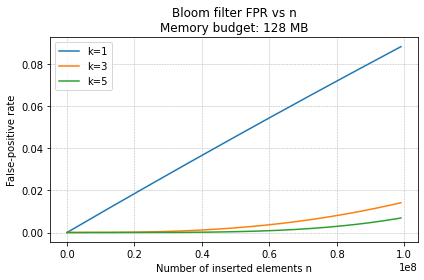

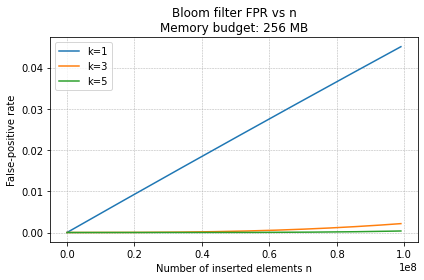

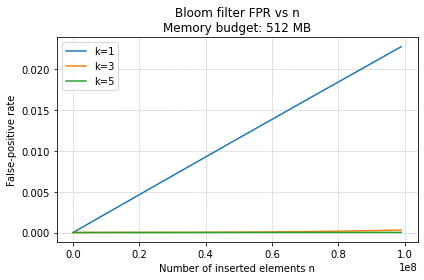

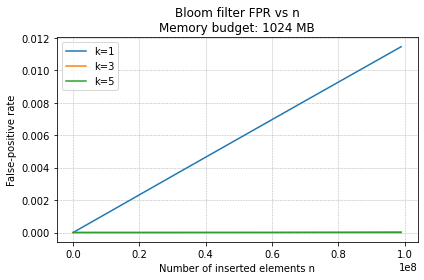

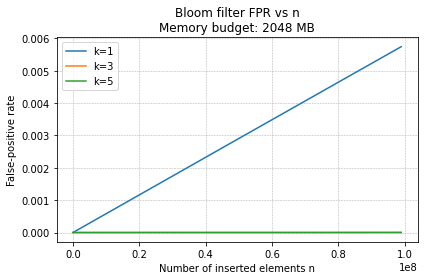

In [43]:
import numpy as np
import matplotlib.pyplot as plt

# --- Helper functions --------------------------------------------------------

def optimal_k(m_bits: int, n_items: int) -> float:
    """
    Optimal number of hash functions for a classic Bloom filter
    given bit‑array size m (in bits) and expected element count n.
    
    k = (m / n) * ln 2
    """
    from math import log
    return (m_bits / n_items) * log(2)

def false_positive_rate(m_bits: int, k: int, n_items: np.ndarray) -> np.ndarray:
    """
    Vectorised computation of Bloom filter false‑positive rate:
    
        f(n) = (1 - exp(-k * n / m)) ** k
    """
    return (1 - np.exp(-k * n_items / m_bits)) ** k

# --- Parameters you can tweak -----------------------------------------------

mem_budgets = 2**np.arange(5) * 128.0 * 8 * 1024 * 1024
for m_bits in mem_budgets:
    # n_elements = 48_000_000
    n_elements = 300_000
    n_updates = region_updates_tpch * n_elements
    n_values = np.linspace(1, n_updates, 500_000)
    k_opt = int(optimal_k(m_bits, (n_updates // 2)))
    # if k_opt < 1:
    k_opt = 3
    k_low = k_opt // 2
    k_high = k_opt + (k_opt - k_low)

    fp_values_low = false_positive_rate(m_bits, k_low, n_values)
    fp_values_opt = false_positive_rate(m_bits, k_opt, n_values)
    fp_values_high = false_positive_rate(m_bits, k_high, n_values)
    
    plt.figure(figsize=(6, 4))
    plt.plot(n_values, fp_values_low, label=f'k={k_low}')
    plt.plot(n_values, fp_values_opt, label=f'k={k_opt}')
    plt.plot(n_values, fp_values_high, label=f'k={k_high}')
    plt.xlabel("Number of inserted elements n")
    plt.ylabel("False‑positive rate")
    plt.title(f"Bloom filter FPR vs n\nMemory budget: {m_bits / 8 / 1024 / 1024:.0f} MB")
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [217]:
m_bits = 100*8*1024*1024
n_star = m_bits / 3 * np.log(2)
false_positive_rate(m_bits, 3, n_star/2)

0.02512626584708365

In [218]:
n_star/2/region_updates_tpch

293663.6355566971

In [199]:
error_eps = rel_eps / region_updates_tpch
CMParameters(delta=delta, error_eps=error_eps).peek_size()

(56065, 5)

In [209]:
rel_eps = 0.0005
levels = 5
delta = 0.01
error_eps = rel_eps / region_updates_tpch
print(CMParameters(delta=delta, error_eps=error_eps).peek_size())
print(CMParameters(delta=delta, error_eps=error_eps).peek_memory())

(1794067, 5)
34.219112396240234


In [211]:
rel_eps / region_updates_tpch

1.5151515151515152e-06

In [213]:
levels = 5
mem_budgets = 2**np.arange(6) * 64
for mem_budget in mem_budgets:
    mem_cms = mem_budget / 2 / levels
    n_counters = mem_cms * 1024 * 1024 / 4
    depth = 3
    width = n_counters // depth
    error_eps = np.e/width
    while error_eps < rel_eps / region_updates_tpch and depth < 5:
        depth += 1
        width = n_counters // depth
        error_eps = np.e/width
    
    if error_eps < rel_eps / region_updates_tpch:
        error_eps = rel_eps / region_updates_tpch
        cms_params = CMParameters(delta=delta, error_eps=error_eps)
    else:
        cms_params = CMParameters(width=width, depth=depth)
    
    print(f"Memory budget: {mem_budget} MB, Width: {cms_params.width}, Depth: {cms_params.depth}, Error epsilon: {error_eps}")
    print(cms_params.peek_memory())

Memory budget: 64 MB, Width: 559240.0, Depth: 3, Error epsilon: 4.860671319038419e-06
6.399993896484375
Memory budget: 128 MB, Width: 1118481.0, Depth: 3, Error epsilon: 2.4303334866296745e-06
12.799999237060547
Memory budget: 256 MB, Width: 1677721.0, Depth: 4, Error epsilon: 1.6202228072838363e-06
25.599990844726562
Memory budget: 512 MB, Width: None, Depth: None, Error epsilon: 1.5151515151515152e-06
34.219112396240234
Memory budget: 1024 MB, Width: None, Depth: None, Error epsilon: 1.5151515151515152e-06
34.219112396240234
Memory budget: 2048 MB, Width: None, Depth: None, Error epsilon: 1.5151515151515152e-06
34.219112396240234


In [197]:
2**np.arange(6) * 64

array([  64,  128,  256,  512, 1024, 2048])

In [192]:
mem_budgets = 2**np.arange(6) * 64.0 * 8 * 1024 * 1024
for m_bits in mem_budgets:
    p_num_index = num_updates_tpch / (num_updates_tpch + region_updates_tpch)
    p_region_index = 1.0 - p_num_index

    n_bits_num_index = int(np.ceil(m_bits * p_num_index))
    n_bits_region_index = int(np.ceil(m_bits * p_region_index))

    n_star_num = n_bits_num_index / 3 * np.log(2)
    n_star_region = n_bits_region_index / 3 * np.log(2)
    print(f"Memory budget: {m_bits / 8 / 1024 / 1024:.0f} MB")
    print(f"Number of elements for num index: {n_star_num/num_updates_tpch:,.0f}")
    print(f"Number of elements for region index: {n_star_region/region_updates_tpch:,.0f}\n")


Memory budget: 64 MB
Number of elements for num index: 313,241
Number of elements for region index: 313,241

Memory budget: 128 MB
Number of elements for num index: 626,482
Number of elements for region index: 626,482

Memory budget: 256 MB
Number of elements for num index: 1,252,965
Number of elements for region index: 1,252,965

Memory budget: 512 MB
Number of elements for num index: 2,505,930
Number of elements for region index: 2,505,930

Memory budget: 1024 MB
Number of elements for num index: 5,011,859
Number of elements for region index: 5,011,859

Memory budget: 2048 MB
Number of elements for num index: 10,023,719
Number of elements for region index: 10,023,719



In [ ]:
mem_budgets = np.arange(10)

In [169]:
CMParameters(delta=delta, error_eps=error_eps).peek_memory() * levels

5.346775054931641

In [187]:
df_path = f"../data/tpch/lineitem_8.parquet"
lineitem_df = pd.read_parquet(df_path)

In [188]:
len(lineitem_df)

47989007

In [214]:
chunks = np.array_split(lineitem_df, 240)

/home/rudi/.local/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [ ]:
import math
import itertools
import mmh3

class CountMinSketch:
    """
    Simple Count-Min Sketch implementation.
    """
    def __init__(self, width, depth, seed=0):
        self.width = width
        self.depth = depth
        self.seed = seed
        self.table = [[0] * width for _ in range(depth)]
        self.hash_seeds = [seed + i * 17 for i in range(depth)]

    def update(self, key, count=1):
        for i, hs in enumerate(self.hash_seeds):
            idx = mmh3.hash(str(key), hs) % self.width
            self.table[i][idx] += count

    def estimate(self, key):
        min_count = math.inf
        for i, hs in enumerate(self.hash_seeds):
            idx = mmh3.hash(str(key), hs) % self.width
            min_count = min(min_count, self.table[i][idx])
        return min_count

class OmniSketch:
    """
    OmniSketch for multidimensional count queries via canonical decomposition.

    Supports d-dimensional data by maintaining a Count-Min Sketch for each
    subset of dimensions (power set). Queries are answered via inclusion-exclusion.
    """
    def __init__(self, dims, width=1000, depth=5, seed=0):
        """
        dims: list of dimension names or indices
        width, depth: parameters for each internal CMS
        """
        self.dims = dims
        self.d = len(dims)
        # create CMS for each non-empty subset of dims
        self.sketches = {}
        for r in range(1, self.d + 1):
            for subset in itertools.combinations(self.dims, r):
                self.sketches[subset] = CountMinSketch(width, depth, seed)

    def _tuple_key(self, record, subset):
        """
        Extracts the tuple of values for the given subset from the record.
        """
        return tuple(record[dim] for dim in subset)

    def update(self, record, count=1):
        """
        Update all sketches with the record count.
        record: dict mapping dims to values
        """
        for subset, sketch in self.sketches.items():
            key = self._tuple_key(record, subset)
            sketch.update(key, count)

    def query(self, predicate):
        """
        Estimate count for a conjunction predicate: dict of dim->value.

        Uses inclusion-exclusion principle over all subsets of the predicate dims.
        predicate: dict mapping some dims to values
        """
        # list of (dim, value) pairs in predicate
        items = list(predicate.items())
        total = 0
        # iterate all non-empty subsets
        for r in range(1, len(items) + 1):
            for comb in itertools.combinations(items, r):
                dims_subset, vals = zip(*comb)
                # sign for inclusion-exclusion
                sign = -1 if (r % 2 == 0) else 1
                key = tuple(vals)
                est = self.sketches[tuple(dims_subset)].estimate(key)
                total += sign * est
        return total

# Example usage:
if __name__ == "__main__":
    dims = ['A', 'B', 'C']
    omni = OmniSketch(dims, width=1000, depth=5)

    # streaming updates
    records = [
        {'A': 'x', 'B': 'y', 'C': 'z'},
        {'A': 'x', 'B': 'y', 'C': 'w'},
        {'A': 'u', 'B': 'v', 'C': 'z'}
    ]
    for rec in records:
        omni.update(rec)

    # query: count where A=x and C=z
    q = {'A': 'x', 'C': 'z'}
    print("Estimated count", omni.query(q))
